# Analysis of Human Kidney Immunne (Lupus Nephritis vs. Healthy control)

## Data source: E-MTAB-13596

## **ScRNA-seq of human kidney immune cells of patients with ANCA-associated glomerulonephritis, Lupus Nephritis against a healthy nephrectomy control**

### "ANCA-associated glomerulonephritis (AGN) associates with a high risk of end-stage kidneydisease. The role of kidney immune cells in local inflammation remains unclear. Herewe investigate kidney immune cell diversity and function. Kidney tissue from AGN patients (n=5) and a lupus nephritis (LN) patient (n=1) were aquired during a biopsy procedure for a clinical indication. Needle-core biopsies were obtained for histopathological examination, and an additional pass was performed to retrieve kidney tissue for scRNA-seq. Healthy kidney tissue (n=1) was obtained from a kidney that was surgically removed do tue due to a (non-invasive) papillary urothelial carcinoma. Immediately after collection, kidney tissue was processed into a single-cell suspension and sorted using a 4-color flow cytometry panel to isolate living, CD45+immune cells. To aid in the multi-omic characterization, surface markers and T and B cell repertoires were sequenced in 2 samples (1 AGN patient and the nephrectomy control). These samples were incubated with an oligo-antibody TotalSeq-C cocktail containing 130 unique cell surface antigens."

In [1]:
PDIR = '/Users/aumchampaneri/VSCode Projects/complement-receptor-blockade/'

# Convert raw data to AnnData object

## Parse metadata

In [2]:
# --- Parse SDRF metadata ---
import pandas as pd
import os
# Use the flat file location, which exists
sdrf_path = f"{PDIR}/lupus-emtab/raw-data/E-MTAB-13596.sdrf.txt"
print("Parsing SDRF metadata from:", sdrf_path)
sdrf = pd.read_csv(sdrf_path, sep="\t")

# Extract relevant columns and sample file info
samples = []
for idx, row in sdrf.iterrows():
    sample_id = row["Source Name"]
    disease = row["Characteristics[disease]"]
    cell_type = row["Characteristics[cell type]"]
    disease_stage = row.get("Characteristics[disease staging]", "")
    # Use the correct columns for file names
    matrix_file = row.get("Protocol REF.44", None)
    barcode_file = row.get("Protocol REF.42", None)
    feature_file = row.get("Protocol REF.43", None)
    # Fallback: infer from sample_id
    if not isinstance(matrix_file, str) or not matrix_file.endswith(".mtx"):
        matrix_file = f"{sample_id}_matrix.mtx"
    if not isinstance(barcode_file, str) or not barcode_file.endswith(".tsv"):
        barcode_file = f"{sample_id}_barcodes.tsv"
    if not isinstance(feature_file, str) or not feature_file.endswith(".tsv"):
        feature_file = f"{sample_id}_features.tsv"
    samples.append({
        "sample_id": sample_id,
        "disease": disease,
        "cell_type": cell_type,
        "disease_stage": disease_stage,
        "matrix_file": matrix_file,
        "barcode_file": barcode_file,
        "feature_file": feature_file,
    })

print(f"Found {len(samples)} samples in SDRF.")

Parsing SDRF metadata from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/E-MTAB-13596.sdrf.txt
Found 7 samples in SDRF.


## Load and annotate all samples

In [3]:
import scipy.io
from anndata.utils import make_index_unique
import pandas as pd
import scanpy as sc

adatas = []
for sample in samples:
    print(f"Loading sample {sample['sample_id']} ...")
    matrix_path = f"{PDIR}/lupus-emtab/raw-data/{sample['matrix_file']}"
    barcode_path = f"{PDIR}/lupus-emtab/raw-data/{sample['barcode_file']}"
    feature_path = f"{PDIR}/lupus-emtab/raw-data/{sample['feature_file']}"
    print(f"Loading matrix from: {matrix_path}")
    # Load matrix
    matrix = scipy.io.mmread(matrix_path)
    # Load barcodes
    barcodes = pd.read_csv(barcode_path, header=None)[0].tolist()
    # Load features
    features = pd.read_csv(feature_path, sep="\t", header=None)
    gene_names = features[1].tolist()  # column 1 is usually gene symbol
    # Check shape and transpose if needed
    if matrix.shape[0] == len(barcodes):
        matrix = matrix.tocsc()
    elif matrix.shape[1] == len(barcodes):
        matrix = matrix.T.tocsc()
    else:
        raise ValueError(f"Matrix dimensions {matrix.shape} do not match barcodes length {len(barcodes)} for sample {sample['sample_id']}.")
    # Diagnostic: check for unique barcodes
    prefixed_barcodes = [f"{sample['sample_id']}_" + bc for bc in barcodes]
    unique_barcodes = set(prefixed_barcodes)
    print(f"Sample {sample['sample_id']} - Total barcodes: {len(barcodes)}, Unique barcodes: {len(unique_barcodes)}")
    # Create AnnData
    ad = sc.AnnData(matrix)
    ad.obs_names = prefixed_barcodes
    ad.var_names = make_index_unique(pd.Index(gene_names))
    # Annotate sample metadata
    ad.obs["sample_id"] = sample["sample_id"]
    ad.obs["disease"] = sample["disease"]
    ad.obs["cell_type_sort"] = sample["cell_type"]
    ad.obs["disease_stage"] = sample["disease_stage"]
    ad.obs["batch"] = sample["sample_id"]
    adatas.append(ad)

print("Merging all samples into a single AnnData object...")
adata = adatas[0].concatenate(
    adatas[1:], batch_key="batch", batch_categories=[s["sample_id"] for s in samples]
)

print(f"Merged AnnData: {adata.n_obs} cells, {adata.n_vars} genes.")
print("AnnData .obs columns:", adata.obs.columns.tolist())
print("Preview of .obs (first 5 rows):")
print(adata.obs.head())

Loading sample AGN1 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN1_matrix.mtx
Sample AGN1 - Total barcodes: 6955, Unique barcodes: 6955
Loading sample AGN2 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN2_matrix.mtx
Sample AGN2 - Total barcodes: 3542, Unique barcodes: 3542
Loading sample AGN3 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN3_matrix.mtx
Sample AGN3 - Total barcodes: 5395, Unique barcodes: 5395
Loading sample AGN4 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN4_matrix.mtx
Sample AGN4 - Total barcodes: 1663, Unique barcodes: 1663
Loading sample AGN5 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN5_matrix.mtx
Sample AGN5 - Total bar

/var/folders/p2/rh6xbt2n0nj6rn3qqpc7s1_m0000gn/T/ipykernel_6315/128507247.py:44: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adatas[0].concatenate(


Merged AnnData: 34993 cells, 20453 genes.
AnnData .obs columns: ['sample_id', 'disease', 'cell_type_sort', 'disease_stage', 'batch']
Preview of .obs (first 5 rows):
                             sample_id  \
AGN1_AAACCCAAGCACCAGA-1-AGN1      AGN1   
AGN1_AAACCCAAGGACAAGA-1-AGN1      AGN1   
AGN1_AAACCCAAGTCACAGG-1-AGN1      AGN1   
AGN1_AAACCCAAGTGCGACA-1-AGN1      AGN1   
AGN1_AAACCCACAAGCCATT-1-AGN1      AGN1   

                                                                     disease  \
AGN1_AAACCCAAGCACCAGA-1-AGN1  anti-neutrophil antibody associated vasculitis   
AGN1_AAACCCAAGGACAAGA-1-AGN1  anti-neutrophil antibody associated vasculitis   
AGN1_AAACCCAAGTCACAGG-1-AGN1  anti-neutrophil antibody associated vasculitis   
AGN1_AAACCCAAGTGCGACA-1-AGN1  anti-neutrophil antibody associated vasculitis   
AGN1_AAACCCACAAGCCATT-1-AGN1  anti-neutrophil antibody associated vasculitis   

                                             cell_type_sort   disease_stage  \
AGN1_AAACCCAAGCACCAGA-

## Save AnnData object

In [4]:
# Save merged AnnData to .h5ad file in /input-data "lupus-emtab/input-data/lupus-emtab_merged.h5ad"
import os
output_dir = f"{PDIR}/lupus-emtab/input-data"
os.makedirs(output_dir, exist_ok=True)
adata.write_h5ad(os.path.join(output_dir, "lupus-emtab_merged.h5ad"))
print(f"Saved AnnData to {os.path.join(output_dir, 'lupus-emtab_merged.h5ad')}")

Saved AnnData to /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/input-data/lupus-emtab_merged.h5ad


# Quality control and processing

In [5]:
adata = sc.read_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_merged.h5ad")

In [6]:
# --- Quality Control (QC) ---
import os
qc_metrics_dir = f"{PDIR}/lupus-emtab/outputs/qc-metrics"
os.makedirs(qc_metrics_dir, exist_ok=True)
qc_metrics_path = os.path.join(qc_metrics_dir, "qc_metrics_emtab.csv")

print("Running quality control...")
sc.pp.filter_cells(adata, min_genes=200)
print(f"After min_genes filter: {adata.n_obs} cells")
sc.pp.filter_genes(adata, min_cells=3)
print(f"After min_cells filter: {adata.n_vars} genes")

# Mitochondrial filtering
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
print(f"Cells with <10% mito: {(adata.obs['pct_counts_mt'] < 10).sum()} / {adata.n_obs}")
adata = adata[adata.obs["pct_counts_mt"] < 10, :]
print(f"After mito filter: {adata.n_obs} cells")

# Save QC metrics
qc_metrics = adata.obs[[
    "n_genes_by_counts",
    "total_counts",
    "pct_counts_mt",
    "sample_id",
    "disease",
    "disease_stage",
]]
qc_metrics.to_csv(qc_metrics_path)
print(f"QC metrics saved to {qc_metrics_path}")

Running quality control...
After min_genes filter: 34290 cells
After min_cells filter: 16949 genes
Cells with <10% mito: 27737 / 34290
After mito filter: 27737 cells
QC metrics saved to /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/outputs/qc-metrics/qc_metrics_emtab.csv


In [7]:
import numpy as np

# Remove cells with zero total counts before normalization
zero_count_cells = adata.X.sum(axis=1) == 0
print(f"Cells with zero total counts before normalization: {zero_count_cells.sum()}")
adata = adata[~zero_count_cells, :]

# Remove cells with any NaN values before normalization
import scipy.sparse
if scipy.sparse.issparse(adata.X):
    nan_cells = np.isnan(adata.X.toarray()).any(axis=1)
else:
    nan_cells = np.isnan(adata.X).any(axis=1)
print(f"Cells with NaN values before normalization: {nan_cells.sum()}")
adata = adata[~nan_cells, :]

Cells with zero total counts before normalization: 0
Cells with NaN values before normalization: 0


In [8]:
# Diagnostics: Check for negative values before normalization/log1p
print("Min value in adata.X before normalization:", adata.X.min())
print("Max value in adata.X before normalization:", adata.X.max())

# --- Save raw counts in .raw before normalization ---
print("Storing raw counts in .raw before normalization/log1p...")
adata.raw = adata.copy()

if adata.X.min() < 0:
    print("Data appears to be already log-transformed or scaled (contains negative values). Skipping normalization/log1p.")
else:
    print("Normalizing and log-transforming...")
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

# Remove cells with any NaN values after normalization/log1p
if scipy.sparse.issparse(adata.X):
    nan_cells_post = np.isnan(adata.X.toarray()).any(axis=1)
else:
    nan_cells_post = np.isnan(adata.X).any(axis=1)
print(f"Cells with NaN values after normalization/log1p: {nan_cells_post.sum()}")
adata = adata[~nan_cells_post, :]

Min value in adata.X before normalization: 0
Max value in adata.X before normalization: 7263
Storing raw counts in .raw before normalization/log1p...
Normalizing and log-transforming...
Cells with NaN values after normalization/log1p: 0


In [9]:
# --- HVG selection ---
print("Selecting highly variable genes...")
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

# --- Scaling and PCA ---
print("Scaling and running PCA...")
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")

Selecting highly variable genes...


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:705: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/Users/aumchampaneri/.pyenv/versions/3.10.18/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Scaling and running PCA...


In [10]:
# --- Harmony batch correction ---
print("Running Harmony batch correction...")
import scanpy.external as sce

print("Harmony will use 'batch' column for integration. Unique batch values:", adata.obs["batch"].unique())
sce.pp.harmony_integrate(adata, "batch")

if "X_pca_harmony" in adata.obsm:
    print("Harmony-corrected PCA found. Using for downstream analysis.")
    print("Shape of X_pca_harmony:", adata.obsm["X_pca_harmony"].shape)
    print("Any NaNs in X_pca_harmony?", np.isnan(adata.obsm["X_pca_harmony"]).any())
    print("Min/Max in X_pca_harmony:", adata.obsm["X_pca_harmony"].min(), adata.obsm["X_pca_harmony"].max())
    adata.obsm["X_pca"] = adata.obsm["X_pca_harmony"]
else:
    print("WARNING: Harmony-corrected PCA not found. Using default PCA.")

Running Harmony batch correction...
Harmony will use 'batch' column for integration. Unique batch values: ['AGN1', 'AGN2', 'AGN3', 'AGN4', 'AGN5', 'LN', 'NC']
Categories (7, object): ['AGN1', 'AGN2', 'AGN3', 'AGN4', 'AGN5', 'LN', 'NC']


2026-02-06 12:21:22,889 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2026-02-06 12:21:28,055 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-02-06 12:21:28,132 - harmonypy - INFO - Iteration 1 of 10
2026-02-06 12:21:34,103 - harmonypy - INFO - Iteration 2 of 10
2026-02-06 12:21:39,483 - harmonypy - INFO - Iteration 3 of 10
2026-02-06 12:21:43,460 - harmonypy - INFO - Iteration 4 of 10
2026-02-06 12:21:46,526 - harmonypy - INFO - Iteration 5 of 10
2026-02-06 12:21:48,931 - harmonypy - INFO - Converged after 5 iterations


Harmony-corrected PCA found. Using for downstream analysis.
Shape of X_pca_harmony: (27737, 50)
Any NaNs in X_pca_harmony? False
Min/Max in X_pca_harmony: -32.1157028060484 61.1691382226257


In [11]:
# --- UMAP and clustering ---
print("Computing neighbors, UMAP, and clustering after Harmony...")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata)

Computing neighbors, UMAP, and clustering after Harmony...


/var/folders/p2/rh6xbt2n0nj6rn3qqpc7s1_m0000gn/T/ipykernel_6315/296598713.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


Displaying UMAP and PCA plots...


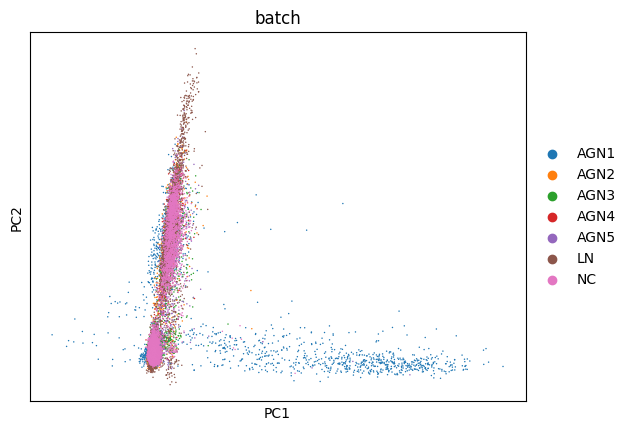

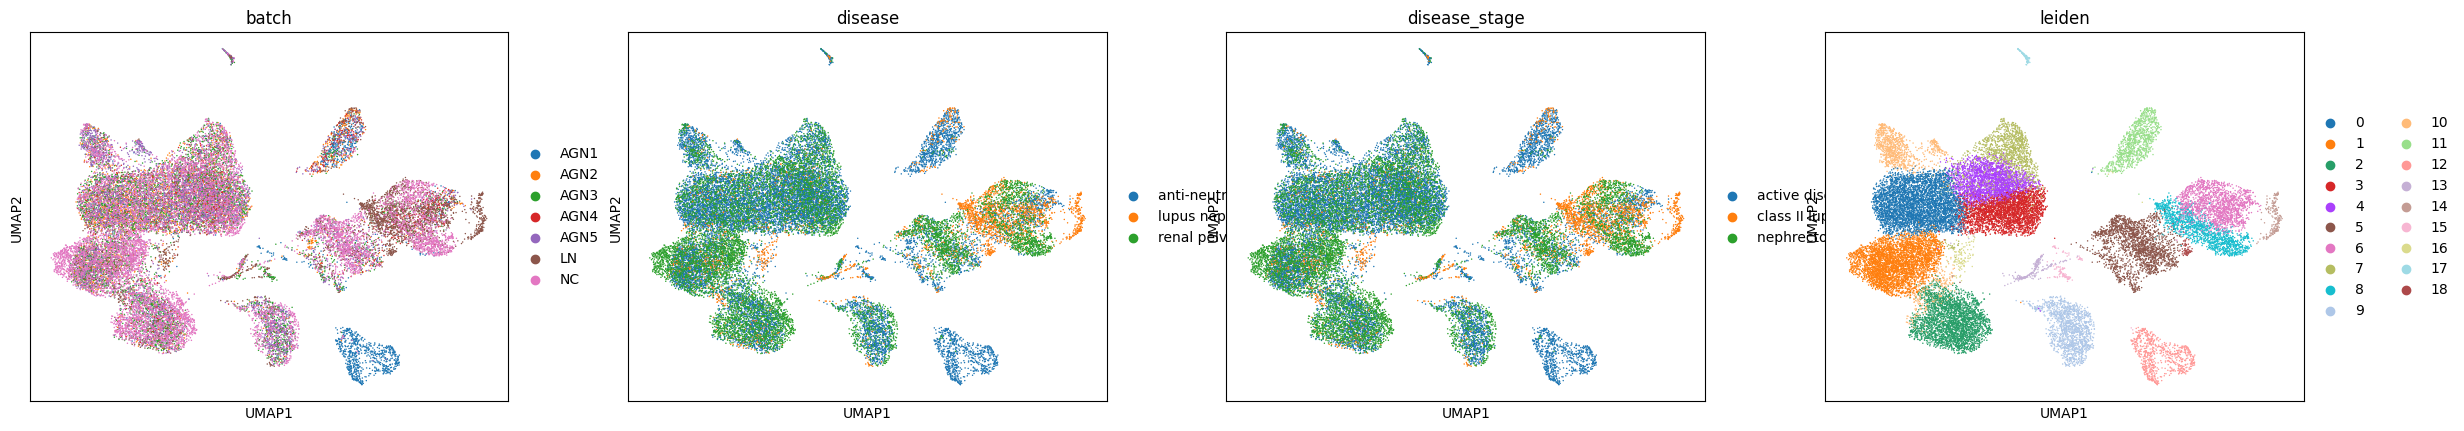

In [12]:
# --- Save diagnostic plots (display in notebook) ---
print("Displaying UMAP and PCA plots...")
sc.pl.pca(adata, color="batch")
sc.pl.umap(
    adata,
    color=["batch", "disease", "disease_stage", "leiden"]
)

## Save AnnData Object

In [13]:
adata.write_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_processed.h5ad")

# Cell type annotation - CellTypist

In [14]:
import scanpy as sc

adata = sc.read_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_processed.h5ad")

In [15]:
# Reset adata.X from adata.raw.X and apply normalization/log1p for CellTypist
import numpy as np
import scanpy as sc
import scipy.sparse
if hasattr(adata, 'raw') and adata.raw is not None:
    print("Resetting adata.X from adata.raw.X (raw counts)...")
    if scipy.sparse.issparse(adata.raw.X):
        adata.X = adata.raw.X.toarray().copy()
    else:
        adata.X = adata.raw.X.copy()
    print(f"After reset, min: {adata.X.min()}, max: {adata.X.max()}")
    print("Normalizing total counts to 1e4 per cell...")
    sc.pp.normalize_total(adata, target_sum=1e4)
    print(f"After normalization, min: {adata.X.min()}, max: {adata.X.max()}")
    print("Applying log1p transformation...")
    sc.pp.log1p(adata)
    print(f"After log1p, min: {adata.X.min()}, max: {adata.X.max()}")
else:
    print("No .raw attribute found. Cannot reset adata.X.")

Resetting adata.X from adata.raw.X (raw counts)...
After reset, min: 0, max: 7263
Normalizing total counts to 1e4 per cell...
After normalization, min: 0.0, max: 5582.37548828125
Applying log1p transformation...
After log1p, min: 0.0, max: 8.627549171447754


In [16]:
import celltypist
import mygene
from celltypist.models import Model
import numpy as np
import os
import pandas as pd
from anndata import AnnData

# Map gene symbols to official gene symbols using mygene
mg = mygene.MyGeneInfo()
result = mg.querymany(list(adata.var.index), scopes="symbol", fields="symbol", species="human")
symbol_map = {r["query"]: r.get("symbol") for r in result if "symbol" in r}
valid_genes = [g for g in adata.var.index if g in symbol_map and symbol_map[g] is not None]
adata = adata[:, valid_genes]
adata.var_names = [symbol_map[g] for g in valid_genes]

# Aggregate duplicated gene symbols by sum
if len(set(adata.var_names)) < len(adata.var_names):
    df = pd.DataFrame(adata.X.toarray(), columns=adata.var_names, index=adata.obs_names)
    df = df.groupby(df.columns, axis=1).sum()
    adata = AnnData(df.values, obs=adata.obs, var=pd.DataFrame(index=df.columns))

# Fill NaNs in .X with zeros
if np.isnan(adata.X).any():
    adata.X = np.nan_to_num(adata.X)

# Final normalization and log1p for CellTypist
if adata.n_obs > 0 and adata.n_vars > 0:
    import scanpy as sc
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.X = np.nan_to_num(adata.X)
else:
    raise ValueError("AnnData is empty before normalization/log1p.")

# Load or download CellTypist model
model_dir = os.path.expanduser("~/.celltypist/data/models")
model_path = os.path.join(model_dir, "Immune_All_Low.pkl")
if os.path.exists(model_path):
    model = Model.load(model_path)
else:
    model = celltypist.models.download_models("Immune_All_Low.pkl")

# Run CellTypist annotation
predictions = celltypist.annotate(adata, model=model, majority_voting=True)
if "majority_voting" in predictions.predicted_labels.columns:
    adata.obs["celltypist_label"] = predictions.predicted_labels["majority_voting"]
else:
    adata.obs["celltypist_label"] = predictions.predicted_labels.iloc[:, 0]

# Save cell type labels to CSV
os.makedirs(f"{PDIR}/lupus-emtab/outputs/", exist_ok=True)
adata.obs["celltypist_label"].to_csv(f"{PDIR}/lupus-emtab/outputs/celltypist_labels.csv")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
querying 1-1000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 1001-2000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 2001-3000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 3001-4000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 4001-5000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 5001-6000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 6001-7000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 7001-8000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 8001-9000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 9001-10000 ...
HTTP Request: POS

🔬 Input data has 27737 cells and 15991 genes
🔗 Matching reference genes in the model
🧬 4956 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


## Check annotations

CellTypist label value counts:
celltypist_label
Tem/Trm cytotoxic T cells      5199
Tem/Temra cytotoxic T cells    3895
CD16+ NK cells                 3170
Tem/Effector helper T cells    2612
Non-classical monocytes        2434
Regulatory T cells             2262
Classical monocytes            1884
Macrophages                    1275
Memory B cells                  873
CD16- NK cells                  835
Tcm/Naive helper T cells        820
Epithelial cells                742
DC2                             706
Naive B cells                   469
ILC3                            139
Plasma cells                     90
Mast cells                       88
NK cells                         78
Type 17 helper T cells           65
Age-associated B cells           55
MAIT cells                       46
Name: count, dtype: int64


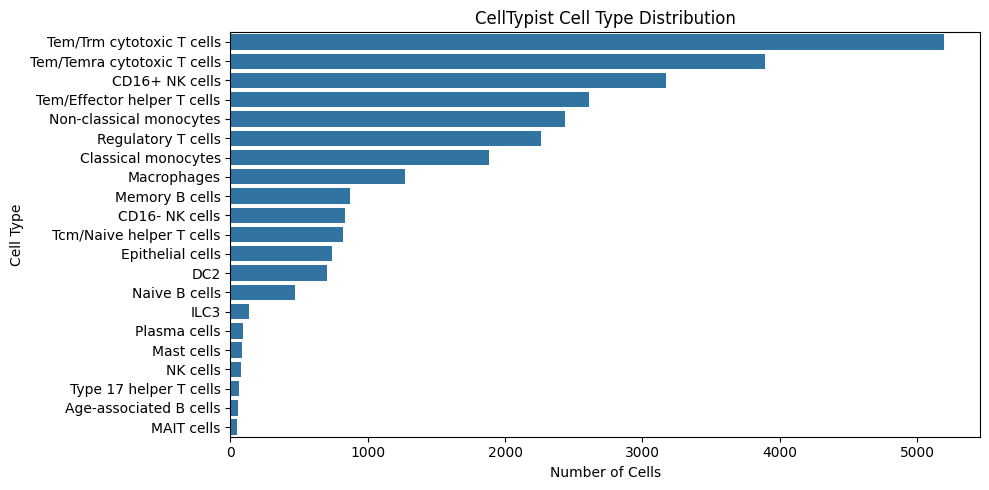


Cell type by disease:
disease                      anti-neutrophil antibody associated vasculitis  \
celltypist_label                                                              
Age-associated B cells                                                   47   
CD16+ NK cells                                                         1443   
CD16- NK cells                                                          618   
Classical monocytes                                                    1148   
DC2                                                                     230   
Epithelial cells                                                        734   
ILC3                                                                    122   
MAIT cells                                                               40   
Macrophages                                                             566   
Mast cells                                                               74   
Memory B cells               

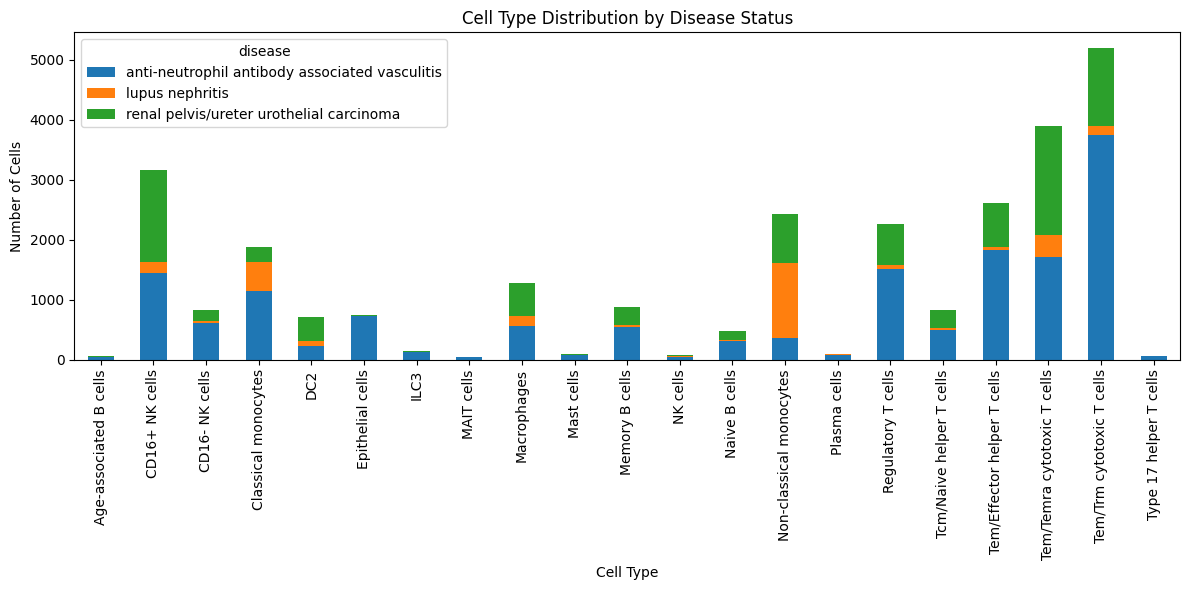

In [17]:
# Check CellTypist annotations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# View unique cell types and counts
print("CellTypist label value counts:")
print(adata.obs["celltypist_label"].value_counts())

# Plot cell type distribution
plt.figure(figsize=(10, 5))
sns.countplot(y=adata.obs["celltypist_label"], order=adata.obs["celltypist_label"].value_counts().index)
plt.title("CellTypist Cell Type Distribution")
plt.xlabel("Number of Cells")
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

# Cross-tabulate cell type by disease
if "disease" in adata.obs.columns:
    ctab = pd.crosstab(adata.obs["celltypist_label"], adata.obs["disease"])
    print("\nCell type by disease:")
    print(ctab)
    ctab.plot(kind="bar", stacked=True, figsize=(12, 6))
    plt.title("Cell Type Distribution by Disease Status")
    plt.xlabel("Cell Type")
    plt.ylabel("Number of Cells")
    plt.tight_layout()
    plt.show()

## Save annotated AnnData object

In [18]:
# Save prepared AnnData object for Geneformer tokenization
adata.write_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_annotated.h5ad")

# Data exploration

In [19]:
import scanpy as sc

# adata = sc.read_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_annotated.h5ad")

adata = sc.read_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_processed.h5ad")

In [20]:
adata

AnnData object with n_obs × n_vars = 27737 × 16949
    obs: 'sample_id', 'disease', 'cell_type_sort', 'disease_stage', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'disease_colors', 'disease_stage_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [21]:
adata.obs

,sample_id,disease,cell_type_sort,disease_stage,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AGN1_AAACCCAAGGACAAGA-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,2099,2099,6441,513,7.964602,4
AGN1_AAAGAACAGGCATGGT-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,366,366,621,28,4.508857,11
AGN1_AAAGAACCAGTGAGCA-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,269,269,519,44,8.477842,11
AGN1_AAAGAACTCTCGCTTG-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,1716,1716,5058,296,5.852115,12
AGN1_AAAGGATAGACGGTCA-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,470,470,916,50,5.458515,11
...,...,...,...,...,...,...,...,...,...,...,...
NC_TTTGTCATCATAACCG-1-NC,NC,renal pelvis/ureter urothelial carcinoma,CD45+ kidney immune cells NC,nephrectomy control,NC,583,583,1213,11,0.906843,6
NC_TTTGTCATCCGCAGTG-1-NC,NC,renal pelvis/ureter urothelial carcinoma,CD45+ kidney immune cells NC,nephrectomy control,NC,2385,2384,8531,259,3.035986,6
NC_TTTGTCATCCTCAACC-1-NC,NC,renal pelvis/ureter urothelial carcinoma,CD45+ kidney immune cells NC,nephrectomy control,NC,1765,1765,6622,195,2.944730,8
NC_TTTGTCATCTTCCTTC-1-NC,NC,renal pelvis/ureter urothelial carcinoma,CD45+ kidney immune cells NC,nephrectomy control,NC,1055,1055,2069,49,2.368294,2


In [22]:
adata.var

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
AL627309.1,124,False,124,0.003791,99.638379,130,True,0.011737,2.550486,2.507151,0.003176,0.078514
FAM87B,22,False,22,0.000671,99.935841,23,False,0.001409,1.316943,0.039877,0.000656,0.028837
LINC00115,617,False,617,0.018956,98.200642,650,False,0.045965,1.217210,-0.159606,0.022350,0.167251
FAM41C,263,False,263,0.007932,99.233013,272,False,0.009206,1.086074,-0.421897,0.004925,0.072128
AL645608.2,16,False,16,0.000467,99.953339,16,True,0.002081,2.174686,1.755495,0.000751,0.034495
...,...,...,...,...,...,...,...,...,...,...,...,...
AC145212.1,344,False,344,0.010878,98.996792,373,False,0.006012,0.916478,-0.761115,0.003393,0.057337
AC011043.1,910,False,910,0.031409,97.346165,1077,False,0.020164,1.287496,-0.019023,0.010327,0.107100
AL592183.1,2358,False,2358,0.105337,93.123360,3612,False,0.066242,1.297952,0.001891,0.033691,0.197142
AC011841.1,29,False,29,0.000962,99.915427,33,False,0.000359,-0.020626,-2.635468,0.000254,0.012773
